<a href="https://colab.research.google.com/github/Raspberry765/Smart_Frige_Raspi/blob/master/AdaCos_288.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://cpp-learning.com/adacos/

In [1]:
import os
# import argparse
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
import joblib
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt


# from utils import *
# from mnist import archs
# import metrics

In [3]:
import os
import sys

from collections import OrderedDict
import joblib
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from sklearn import manifold
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.neighbors import LocalOutlierFactor
import torch
from torch import nn, Tensor
from torch import optim
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
from torchsummary import summary
from PIL import Image
from tqdm import tqdm
from typing import Tuple

In [4]:
use_cuda = torch.cuda.is_available() and True
device = torch.device("cuda" if use_cuda else "cpu")

In [23]:
transform = transforms.Compose(
        [transforms.ToTensor(),transforms.Resize((288,288)) ]
    ) #硬貨のためのtransform

train_set = datasets.MNIST(
        root='MNIST',
        train=True,
        download=True,
        transform=transform)

val_set = datasets.MNIST(
        root='MNIST',
        train=False,
        download=True,
        transform=transform)

train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=128,
        shuffle=True,
        num_workers=8)

validation_dataloader = torch.utils.data.DataLoader(
        val_set,
        batch_size=128,
        shuffle=False,
        num_workers=8)

In [ ]:
print("train_setサイズ:", len(train_set), "先頭10個の真値:", [train_set[i][1] for i in range(10)])
ds_1 = torch.utils.data.Subset(train_set, [0, 2, 5]) # 任意位置の抜き取り
print("サイズ:", len(ds_1), "ds_1 真値 index[0, 2, 5]:", [ds_1[i][1] for i in range(3)])
ds_2 = torch.utils.data.ConcatDataset([ds_1, ds_1, ds_1]) # データセットを連結
print("サイズ:", len(ds_2), "ConcatDataset([ds_1, ds_1, ds_1])の結果真値:", [ds_2[i][1] for i in range(9)])

train_val_set = torch.utils.data.ConcatDataset([train_set, val_set]) # データセットを連結
train_val_set_loader = torch.utils.data.DataLoader(
        train_val_set,
        batch_size=128,
        shuffle=True,
        num_workers=8)

train_setサイズ: 60000 先頭10個の真値: [5, 0, 4, 1, 9, 2, 1, 3, 1, 4]
サイズ: 3 ds_1 真値 index[0, 2, 5]: [5, 4, 2]
サイズ: 9 ConcatDataset([ds_1, ds_1, ds_1])の結果真値: [5, 4, 2, 5, 4, 2, 5, 4, 2]


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


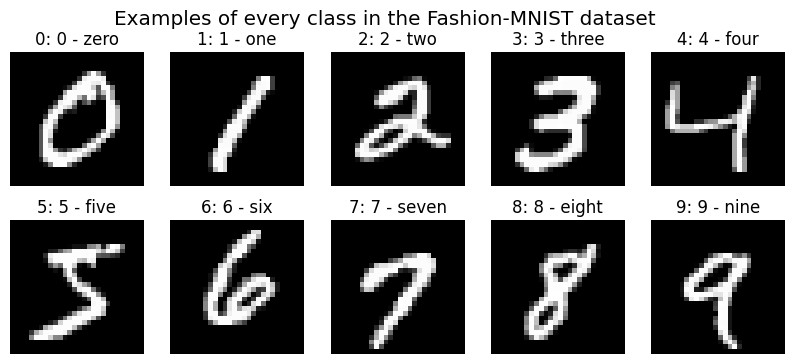

In [ ]:
# 各クラスのラベルを持つサンプルを1つずつ取得する。
import matplotlib.pyplot as plt
class_ids, sample_indices = np.unique(train_set.targets, return_index=True)

fig = plt.figure(figsize=(10, 4))
fig.suptitle(
    "Examples of every class in the Fashion-MNIST dataset", fontsize="x-large"
)

for i in class_ids:
    img = train_set.data[sample_indices[i]]
    class_name = train_set.classes[i]

    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_title(f"{i}: {class_name}")
    ax.set_axis_off()
    ax.imshow(img, cmap="gray")

plt.show()

データセットの数: 10000
データセットの情報: 2
type(img): <class 'torch.Tensor'>


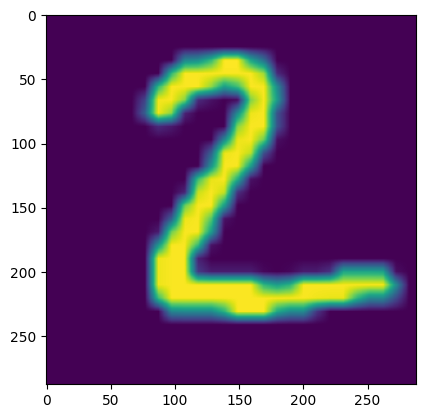

In [ ]:
# データセットの確認
dataset_index=1
print("データセットの数:",len(val_set))
print("データセットの情報:", val_set[dataset_index][1])
img =  val_set[dataset_index][0]
img = torch.squeeze(img)
plt.imshow(img)
print("type(img):",type(img))
#test = MyDatasets(train_datasets,transform)

In [14]:
# # 288×288のサイズのモデル

output_class = 10

class Net_288(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(38088*2, 115)
        self.fc2 = nn.Linear(115, 84)
        self.fc3 = nn.Linear(84, 128)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 38088*2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class NetClf(nn.Module):
    def __init__(self):
        super(NetClf, self).__init__()
        self.fc = nn.Linear(128, output_class)

    def forward(self, x):
        x = self.fc(x)
        #return F.log_softmax(x,dim=1)
        return x

In [15]:
class AdaCos(nn.Module):
    def __init__(self, num_features, num_classes, m=0.50):
        super(AdaCos, self).__init__()
        self.num_features = num_features
        # self.n_classes = num_classes
        self.s = math.sqrt(2) * math.log(num_classes - 1)
        self.m = m
        self.W = Parameter(torch.FloatTensor(num_classes, num_features))
        nn.init.xavier_uniform_(self.W)

    def forward(self, input, label):
        # normalize features
        x = F.normalize(input)
        # normalize weights
        W = F.normalize(self.W)
        # dot product
        logits = F.linear(x, W)
        # add margin
        theta = torch.acos(torch.clamp(logits, -1.0 + 1e-7, 1.0 - 1e-7))
        target_logits = torch.cos(theta + self.m)
        one_hot = torch.zeros_like(logits)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        output = logits * (1 - one_hot) + target_logits * one_hot
        # feature re-scale
        with torch.no_grad():
            B_avg = torch.where(one_hot < 1, self.s * torch.exp(logits), torch.zeros_like(logits))
            B_avg = torch.sum(B_avg) / input.size(0)
            # print(B_avg)
            theta_med = torch.median(theta)
            self.s = torch.log(B_avg) / torch.cos(torch.min(math.pi/4 * torch.ones_like(theta_med), theta_med))
        # print(self.s)
        output *= self.s

        return output

In [16]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [17]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [18]:
def train(train_loader, model, metric_fc, criterion, optimizer, modelclf, optimizerclf):
    losses = AverageMeter()
    loss1s = AverageMeter()
    loss2s = AverageMeter()
    acc1s = AverageMeter()
    acc1cs = AverageMeter()

    # switch to train mode
    model.train()
    metric_fc.train()
    modelclf.train()

    for i, (data, label) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, label = data.to(device), label.to(device)

        feature = model(data)
        output = metric_fc(feature, label)
        outputc = modelclf(feature)
        loss1 = criterion(output, label)
        loss2 = criterion(outputc, label)
        loss = loss1 + loss2

        acc1, = accuracy(output, label, topk=(1,))
        acc1c, = accuracy(outputc, label, topk=(1,))

        losses.update(loss.item(), data.size(0))
        loss1s.update(loss1.item(), data.size(0))
        loss2s.update(loss2.item(), data.size(0))
        acc1s.update(acc1.item(), data.size(0))
        acc1cs.update(acc1c.item(), data.size(0))

        # compute gradient and do optimizing step
        optimizer.zero_grad()
        optimizerclf.zero_grad()
        loss.backward()
        optimizer.step()
        optimizerclf.step()

    log = OrderedDict([
        ('loss', losses.avg),
        ('loss1',loss1s.avg),
        ('loss2',loss2s.avg),
        ('acc1', acc1s.avg),
        ('acc1c',acc1cs.avg),
    ])

    return log

In [19]:
#def validate(val_loader, model, metric_fc, criterion):
def validate(val_loader, model, metric_fc, criterion, modelclf):
    losses = AverageMeter()
    loss1s = AverageMeter()
    loss2s = AverageMeter()
    acc1s = AverageMeter()
    acc1cs = AverageMeter()

    # switch to evaluate mode
    model.eval()
    metric_fc.eval()
    modelclf.eval()

    with torch.no_grad():
        for i, (data, label) in tqdm(enumerate(val_loader), total=len(val_loader)):
            data,label = data.to(device),label.to(device)

            feature = model(data)
            output = metric_fc(feature, label)
            outputc = modelclf(feature)
            loss1 = criterion(output, label)
            loss2 = criterion(outputc, label)
            loss = loss1 + loss2
            acc1, = accuracy(output, label, topk=(1,))
            acc1c, = accuracy(outputc, label, topk=(1,))

            losses.update(loss.item(), data.size(0))
            loss1s.update(loss1.item(), data.size(0))
            loss2s.update(loss2.item(), data.size(0))
            acc1s.update(acc1.item(), data.size(0))
            acc1cs.update(acc1c.item(), data.size(0))

    log = OrderedDict([
        ('loss', losses.avg),
        ('loss1',loss1s.avg),
        ('loss2',loss2s.avg),
        ('acc1', acc1s.avg),
        ('acc1c',acc1cs.avg),
    ])

    return log

In [20]:
epochs=20

# class分類数をデータセットに合わせる
# embedding用モデル
model = Net_288().to(device)
num_features = model.fc3.out_features
metric_fc = AdaCos(num_features, num_classes=16).to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
# optimizer = optim.Adam(model.parameters(), lr=0.02)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

# embeddings→16クラス分類モデル
modelclf = NetClf().to(device)
optimizerclf = optim.SGD(modelclf.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)

In [25]:
log = pd.DataFrame(index=[],
                   columns=[ 'epoch', 'lr', 'loss', 'loss1','loss2','acc1','acc1c'
                            , 'val_loss', 'val_loss1','val_loss2','val_acc1','val_acc1c'])
best_loss = float('inf')

for epoch in range(epochs):
    print('Epoch [%d/%d]' %(epoch+1, epochs))

    scheduler.step()

    # train for one epoch
    train_log = train(train_loader, model, metric_fc, criterion, optimizer, modelclf, optimizerclf)
    # evaluate on validation set
    val_log = validate(validation_dataloader, model, metric_fc, criterion, modelclf)
    print('loss %f - acc1 %f - val_loss %f - val_acc %f'
            %(train_log['loss'], train_log['acc1'], val_log['loss'], val_log['acc1']))

    tmp = pd.Series([
            epoch,
            scheduler.get_lr()[0],
            train_log['loss'],
            train_log['loss1'],
            train_log['loss2'],
            train_log['acc1'],
            train_log['acc1c'],
            val_log['loss'],
            val_log['loss1'],
            val_log['loss2'],
            val_log['acc1'],
            val_log['acc1c'],
        ], index=['epoch', 'lr', 'loss','loss1','loss2','acc1','acc1c'
                  ,'val_loss','val_loss1','val_loss2', 'val_acc1','val_acc1c'])

    log = log.append(tmp, ignore_index=True)
    log.to_csv('./models_log.csv', index=False)

    if val_log['loss'] < best_loss:
        torch.save({
            'model':model.state_dict(),
            'metric_fc':metric_fc.state_dict(),
            'optimizer':optimizer.state_dict(),
            'modelclf':modelclf.state_dict(),
            'optimizerclf':optimizerclf.state_dict(),
        },'./model.pt')
        best_loss = val_log['loss']
        print("=> saved best model")

Epoch [1/20]


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

loss 2.036300 - acc1 66.920000 - val_loss 0.876737 - val_acc 86.730000
=> saved best model
Epoch [2/20]


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

loss 0.772669 - acc1 88.890000 - val_loss 0.653913 - val_acc 90.660000
=> saved best model
Epoch [3/20]


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

loss 0.597069 - acc1 91.633333 - val_loss 0.560587 - val_acc 92.510000
=> saved best model
Epoch [4/20]


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

loss 0.507957 - acc1 93.161667 - val_loss 0.498036 - val_acc 93.590000
=> saved best model
Epoch [5/20]


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

loss 0.446327 - acc1 94.245000 - val_loss 0.463225 - val_acc 94.130000
=> saved best model
Epoch [6/20]


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

loss 0.403451 - acc1 94.960000 - val_loss 0.425534 - val_acc 94.920000
=> saved best model
Epoch [7/20]


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

loss 0.376076 - acc1 95.316667 - val_loss 0.416961 - val_acc 94.910000
=> saved best model
Epoch [8/20]


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

loss 0.348460 - acc1 95.806667 - val_loss 0.391017 - val_acc 95.330000
=> saved best model
Epoch [9/20]


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

loss 0.324914 - acc1 96.148333 - val_loss 0.395680 - val_acc 95.470000
Epoch [10/20]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-25-4fbc49c38c3a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.307486 - acc1 96.541667 - val_loss 0.364355 - val_acc 96.020000
=> saved best model
Epoch [11/20]


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

loss 0.288355 - acc1 96.773333 - val_loss 0.361362 - val_acc 95.850000
=> saved best model
Epoch [12/20]


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

loss 0.269441 - acc1 97.051667 - val_loss 0.377666 - val_acc 95.830000
Epoch [13/20]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-25-4fbc49c38c3a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.258310 - acc1 97.180000 - val_loss 0.392288 - val_acc 95.350000
Epoch [14/20]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-25-4fbc49c38c3a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.249462 - acc1 97.416667 - val_loss 0.360072 - val_acc 96.180000
=> saved best model
Epoch [15/20]


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

loss 0.236025 - acc1 97.588333 - val_loss 0.363481 - val_acc 96.290000
Epoch [16/20]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-25-4fbc49c38c3a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.228252 - acc1 97.700000 - val_loss 0.342827 - val_acc 96.490000
=> saved best model
Epoch [17/20]


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

loss 0.219293 - acc1 97.843333 - val_loss 0.343861 - val_acc 96.500000
Epoch [18/20]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-25-4fbc49c38c3a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.212844 - acc1 97.915000 - val_loss 0.332915 - val_acc 96.620000
=> saved best model
Epoch [19/20]


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

loss 0.198215 - acc1 98.170000 - val_loss 0.340787 - val_acc 96.630000
Epoch [20/20]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-25-4fbc49c38c3a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.194670 - acc1 98.210000 - val_loss 0.340390 - val_acc 96.680000



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-25-4fbc49c38c3a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)


In [26]:
# 保存したモデル・オプティマイザーがロードできるか確認
model_load = Net_288().to(device)
num_features_load = model_load.fc3.out_features
metric_fc_load = AdaCos(num_features, num_classes=16).to(device)
optimizer_load = optim.SGD(model_load.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
modelclf_load = NetClf().to(device)
optimizerclf_load = optim.SGD(modelclf_load.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)

checkpoint = torch.load('./model.pt')
model_load.load_state_dict(checkpoint['model'])
metric_fc_load.load_state_dict(checkpoint['metric_fc'])
optimizer_load.load_state_dict(checkpoint['optimizer'])
modelclf_load.load_state_dict(checkpoint['modelclf'])
optimizerclf_load.load_state_dict(checkpoint['optimizerclf'])

Text(0.5, 1.0, 'loss')

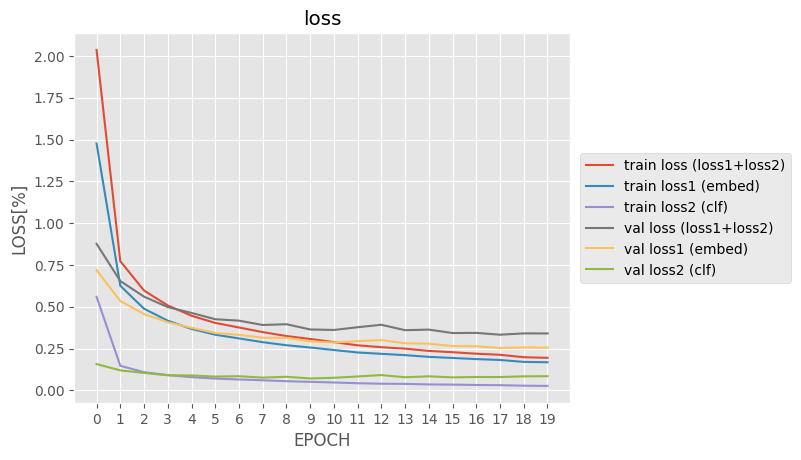

In [27]:
da=pd.read_csv('./models_log.csv')
plt.style.use('ggplot')
plt.plot(da["epoch"],da["loss"], label='train loss (loss1+loss2)')
plt.plot(da["epoch"],da["loss1"], label='train loss1 (embed)')
plt.plot(da["epoch"],da["loss2"], label='train loss2 (clf)')
plt.plot(da["epoch"],da["val_loss"], label='val loss (loss1+loss2)')
plt.plot(da["epoch"],da["val_loss1"], label='val loss1 (embed)')
plt.plot(da["epoch"],da["val_loss2"], label='val loss2 (clf)')
plt.legend(loc="center left",bbox_to_anchor=(1.02,0.5,), borderaxespad=0)
plt.xticks(np.arange(0, len(da["epoch"]), step=1))
plt.xlabel('EPOCH')
plt.ylabel('LOSS[%]')
plt.title('loss')
#plt.grid()

Text(0.5, 1.0, 'accuracy')

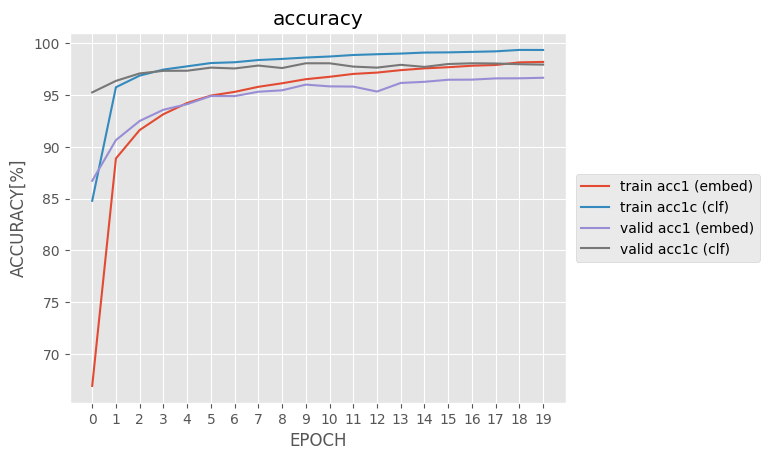

In [28]:
plt.style.use('ggplot')
plt.plot(da["acc1"], label='train acc1 (embed)')
plt.plot(da["acc1c"], label='train acc1c (clf)')
plt.plot(da["val_acc1"], label='valid acc1 (embed)')
plt.plot(da["val_acc1c"], label='valid acc1c (clf)')
plt.xticks(np.arange(0, len(da["epoch"]), step=1))
plt.xlabel('EPOCH')
plt.ylabel('ACCURACY[%]')
#plt.legend(['train acc', 'val acc'])
plt.legend(loc="center left",bbox_to_anchor=(1.02,0.5,), borderaxespad=0)
plt.title('accuracy')

In [29]:
from sklearn.neighbors import LocalOutlierFactor

results = np.zeros((1,128))
for img, label in tqdm(train_loader):
    img, label = img.to(device), label.to(device)
    pred = model(img)
    #print(pred.shape)
    pred_num = pred.to("cpu").detach().numpy().copy()
    print(results.shape)
    results = np.concatenate([results, pred_num])

print(results.shape)
results[0,:]

results_del = np.delete(results, 0, 0)
print(results_del)
print(results_del.shape)

clf = LocalOutlierFactor(n_neighbors=22, novelty=True, contamination=0.0001)
clf.fit(results_del)

  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

(1, 128)
(129, 128)
(257, 128)
(385, 128)


  1%|▏         | 7/469 [00:00<00:47,  9.74it/s]

(513, 128)
(641, 128)
(769, 128)
(897, 128)


  3%|▎         | 12/469 [00:01<00:31, 14.59it/s]

(1025, 128)
(1153, 128)
(1281, 128)
(1409, 128)
(1537, 128)


  4%|▍         | 18/469 [00:01<00:24, 18.71it/s]

(1665, 128)
(1793, 128)
(1921, 128)
(2049, 128)
(2177, 128)


  4%|▍         | 21/469 [00:01<00:21, 20.39it/s]

(2305, 128)
(2433, 128)
(2561, 128)
(2689, 128)
(2817, 128)


  6%|▌         | 27/469 [00:01<00:19, 22.65it/s]

(2945, 128)
(3073, 128)
(3201, 128)
(3329, 128)
(3457, 128)
(3585, 128)


  7%|▋         | 33/469 [00:02<00:19, 22.89it/s]

(3713, 128)
(3841, 128)
(3969, 128)
(4097, 128)
(4225, 128)


  8%|▊         | 39/469 [00:02<00:18, 23.69it/s]

(4353, 128)
(4481, 128)
(4609, 128)
(4737, 128)
(4865, 128)


  9%|▉         | 42/469 [00:02<00:17, 23.86it/s]

(4993, 128)
(5121, 128)
(5249, 128)
(5377, 128)
(5505, 128)
(5633, 128)

 10%|█         | 48/469 [00:02<00:18, 23.34it/s]


(5761, 128)
(5889, 128)
(6017, 128)
(6145, 128)


 12%|█▏        | 54/469 [00:03<00:18, 22.97it/s]

(6273, 128)
(6401, 128)
(6529, 128)
(6657, 128)
(6785, 128)


 12%|█▏        | 57/469 [00:03<00:17, 23.14it/s]

(6913, 128)
(7041, 128)
(7169, 128)
(7297, 128)
(7425, 128)


 13%|█▎        | 63/469 [00:03<00:17, 23.57it/s]

(7553, 128)
(7681, 128)
(7809, 128)
(7937, 128)
(8065, 128)
(8193, 128)


 15%|█▍        | 69/469 [00:03<00:16, 23.94it/s]

(8321, 128)
(8449, 128)
(8577, 128)
(8705, 128)
(8833, 128)


 16%|█▌        | 75/469 [00:03<00:16, 24.41it/s]

(8961, 128)
(9089, 128)
(9217, 128)
(9345, 128)
(9473, 128)
(9601, 128)


 17%|█▋        | 81/469 [00:04<00:15, 24.42it/s]

(9729, 128)
(9857, 128)
(9985, 128)
(10113, 128)
(10241, 128)


 18%|█▊        | 84/469 [00:04<00:16, 23.90it/s]

(10369, 128)
(10497, 128)
(10625, 128)
(10753, 128)
(10881, 128)


 19%|█▉        | 90/469 [00:04<00:15, 24.35it/s]

(11009, 128)
(11137, 128)
(11265, 128)
(11393, 128)
(11521, 128)


 20%|██        | 96/469 [00:04<00:15, 23.48it/s]

(11649, 128)
(11777, 128)
(11905, 128)
(12033, 128)
(12161, 128)


 21%|██        | 99/469 [00:04<00:16, 22.64it/s]

(12289, 128)
(12417, 128)
(12545, 128)
(12673, 128)
(12801, 128)


 22%|██▏       | 105/469 [00:05<00:16, 22.56it/s]

(12929, 128)
(13057, 128)
(13185, 128)
(13313, 128)
(13441, 128)


 24%|██▎       | 111/469 [00:05<00:15, 22.67it/s]

(13569, 128)
(13697, 128)
(13825, 128)
(13953, 128)
(14081, 128)


 24%|██▍       | 114/469 [00:05<00:15, 22.56it/s]

(14209, 128)
(14337, 128)
(14465, 128)
(14593, 128)
(14721, 128)


 26%|██▌       | 120/469 [00:05<00:15, 22.25it/s]

(14849, 128)
(14977, 128)
(15105, 128)
(15233, 128)
(15361, 128)


 27%|██▋       | 126/469 [00:06<00:15, 22.02it/s]

(15489, 128)
(15617, 128)
(15745, 128)
(15873, 128)
(16001, 128)


 28%|██▊       | 129/469 [00:06<00:15, 21.60it/s]

(16129, 128)
(16257, 128)
(16385, 128)
(16513, 128)
(16641, 128)


 29%|██▉       | 135/469 [00:06<00:15, 21.16it/s]

(16769, 128)
(16897, 128)
(17025, 128)
(17153, 128)
(17281, 128)


 30%|███       | 141/469 [00:06<00:15, 21.42it/s]

(17409, 128)
(17537, 128)
(17665, 128)
(17793, 128)
(17921, 128)


 31%|███       | 144/469 [00:06<00:14, 21.95it/s]

(18049, 128)
(18177, 128)
(18305, 128)
(18433, 128)
(18561, 128)


 32%|███▏      | 150/469 [00:07<00:14, 22.30it/s]

(18689, 128)
(18817, 128)
(18945, 128)
(19073, 128)
(19201, 128)


 33%|███▎      | 156/469 [00:07<00:14, 22.09it/s]

(19329, 128)
(19457, 128)
(19585, 128)
(19713, 128)
(19841, 128)


 34%|███▍      | 159/469 [00:07<00:13, 22.20it/s]

(19969, 128)
(20097, 128)
(20225, 128)
(20353, 128)
(20481, 128)


 35%|███▌      | 165/469 [00:07<00:13, 22.81it/s]

(20609, 128)
(20737, 128)
(20865, 128)
(20993, 128)
(21121, 128)


 36%|███▋      | 171/469 [00:08<00:13, 22.19it/s]

(21249, 128)
(21377, 128)
(21505, 128)
(21633, 128)
(21761, 128)


 37%|███▋      | 174/469 [00:08<00:13, 22.36it/s]

(21889, 128)
(22017, 128)
(22145, 128)
(22273, 128)
(22401, 128)


 38%|███▊      | 180/469 [00:08<00:13, 21.82it/s]

(22529, 128)
(22657, 128)
(22785, 128)
(22913, 128)
(23041, 128)


 40%|███▉      | 186/469 [00:08<00:12, 21.87it/s]

(23169, 128)
(23297, 128)
(23425, 128)
(23553, 128)
(23681, 128)


 40%|████      | 189/469 [00:08<00:12, 22.20it/s]

(23809, 128)
(23937, 128)
(24065, 128)
(24193, 128)
(24321, 128)


 42%|████▏     | 195/469 [00:09<00:12, 21.76it/s]

(24449, 128)
(24577, 128)
(24705, 128)
(24833, 128)
(24961, 128)


 43%|████▎     | 201/469 [00:09<00:12, 21.62it/s]

(25089, 128)
(25217, 128)
(25345, 128)
(25473, 128)
(25601, 128)


 43%|████▎     | 204/469 [00:09<00:12, 21.37it/s]

(25729, 128)
(25857, 128)
(25985, 128)
(26113, 128)
(26241, 128)


 45%|████▍     | 210/469 [00:09<00:11, 21.73it/s]

(26369, 128)
(26497, 128)
(26625, 128)
(26753, 128)
(26881, 128)


 46%|████▌     | 216/469 [00:10<00:11, 21.19it/s]

(27009, 128)
(27137, 128)
(27265, 128)
(27393, 128)
(27521, 128)


 47%|████▋     | 219/469 [00:10<00:11, 21.59it/s]

(27649, 128)
(27777, 128)
(27905, 128)
(28033, 128)
(28161, 128)


 48%|████▊     | 225/469 [00:10<00:11, 20.93it/s]

(28289, 128)
(28417, 128)
(28545, 128)
(28673, 128)
(28801, 128)


 49%|████▉     | 231/469 [00:10<00:11, 20.89it/s]

(28929, 128)
(29057, 128)
(29185, 128)
(29313, 128)
(29441, 128)


 50%|████▉     | 234/469 [00:11<00:11, 20.78it/s]

(29569, 128)
(29697, 128)
(29825, 128)
(29953, 128)
(30081, 128)


 51%|█████     | 240/469 [00:11<00:10, 21.27it/s]

(30209, 128)
(30337, 128)
(30465, 128)
(30593, 128)
(30721, 128)


 52%|█████▏    | 246/469 [00:11<00:10, 21.20it/s]

(30849, 128)
(30977, 128)
(31105, 128)
(31233, 128)
(31361, 128)


 53%|█████▎    | 249/469 [00:11<00:10, 20.74it/s]

(31489, 128)
(31617, 128)
(31745, 128)
(31873, 128)


 54%|█████▍    | 255/469 [00:12<00:10, 20.99it/s]

(32001, 128)
(32129, 128)
(32257, 128)
(32385, 128)
(32513, 128)


 55%|█████▌    | 258/469 [00:12<00:10, 20.96it/s]

(32641, 128)
(32769, 128)
(32897, 128)
(33025, 128)
(33153, 128)


 56%|█████▋    | 264/469 [00:12<00:09, 20.67it/s]

(33281, 128)
(33409, 128)
(33537, 128)
(33665, 128)
(33793, 128)


 57%|█████▋    | 267/469 [00:12<00:09, 20.65it/s]

(33921, 128)
(34049, 128)
(34177, 128)
(34305, 128)
(34433, 128)


 58%|█████▊    | 273/469 [00:13<00:09, 20.20it/s]

(34561, 128)
(34689, 128)
(34817, 128)
(34945, 128)
(35073, 128)


 59%|█████▉    | 279/469 [00:13<00:09, 20.49it/s]

(35201, 128)
(35329, 128)
(35457, 128)
(35585, 128)
(35713, 128)


 60%|██████    | 282/469 [00:13<00:09, 20.10it/s]

(35841, 128)
(35969, 128)
(36097, 128)
(36225, 128)
(36353, 128)


 61%|██████▏   | 288/469 [00:13<00:08, 20.50it/s]

(36481, 128)
(36609, 128)
(36737, 128)
(36865, 128)
(36993, 128)


 63%|██████▎   | 294/469 [00:14<00:08, 20.32it/s]

(37121, 128)
(37249, 128)
(37377, 128)
(37505, 128)


 63%|██████▎   | 297/469 [00:14<00:08, 20.08it/s]

(37633, 128)
(37761, 128)
(37889, 128)
(38017, 128)
(38145, 128)


 65%|██████▍   | 303/469 [00:14<00:08, 19.95it/s]

(38273, 128)
(38401, 128)
(38529, 128)
(38657, 128)


 65%|██████▌   | 306/469 [00:14<00:08, 20.28it/s]

(38785, 128)
(38913, 128)
(39041, 128)
(39169, 128)
(39297, 128)


 66%|██████▋   | 311/469 [00:14<00:07, 19.85it/s]

(39425, 128)
(39553, 128)
(39681, 128)
(39809, 128)


 67%|██████▋   | 316/469 [00:15<00:07, 20.17it/s]

(39937, 128)
(40065, 128)
(40193, 128)
(40321, 128)
(40449, 128)


 68%|██████▊   | 319/469 [00:15<00:07, 19.99it/s]

(40577, 128)
(40705, 128)
(40833, 128)
(40961, 128)
(41089, 128)


 69%|██████▉   | 325/469 [00:15<00:07, 20.00it/s]

(41217, 128)
(41345, 128)
(41473, 128)
(41601, 128)


 70%|███████   | 330/469 [00:15<00:07, 19.35it/s]

(41729, 128)
(41857, 128)
(41985, 128)
(42113, 128)


 71%|███████   | 332/469 [00:15<00:07, 19.18it/s]

(42241, 128)
(42369, 128)
(42497, 128)
(42625, 128)
(42753, 128)


 72%|███████▏  | 339/469 [00:16<00:06, 19.18it/s]

(42881, 128)
(43009, 128)
(43137, 128)
(43265, 128)


 73%|███████▎  | 342/469 [00:16<00:06, 19.83it/s]

(43393, 128)
(43521, 128)
(43649, 128)
(43777, 128)


 74%|███████▍  | 346/469 [00:16<00:06, 19.33it/s]

(43905, 128)
(44033, 128)
(44161, 128)
(44289, 128)


 75%|███████▍  | 350/469 [00:16<00:06, 19.36it/s]

(44417, 128)
(44545, 128)
(44673, 128)
(44801, 128)


 75%|███████▌  | 354/469 [00:17<00:06, 18.50it/s]

(44929, 128)
(45057, 128)
(45185, 128)
(45313, 128)


 76%|███████▋  | 358/469 [00:17<00:06, 17.58it/s]

(45441, 128)
(45569, 128)
(45697, 128)
(45825, 128)


 77%|███████▋  | 362/469 [00:17<00:05, 18.11it/s]

(45953, 128)
(46081, 128)
(46209, 128)
(46337, 128)


 78%|███████▊  | 366/469 [00:17<00:05, 17.80it/s]

(46465, 128)
(46593, 128)
(46721, 128)
(46849, 128)


 79%|███████▉  | 370/469 [00:18<00:05, 17.95it/s]

(46977, 128)
(47105, 128)
(47233, 128)
(47361, 128)


 80%|███████▉  | 374/469 [00:18<00:05, 18.11it/s]

(47489, 128)
(47617, 128)
(47745, 128)
(47873, 128)


 81%|████████  | 378/469 [00:18<00:04, 18.25it/s]

(48001, 128)
(48129, 128)
(48257, 128)
(48385, 128)


 81%|████████▏ | 382/469 [00:18<00:04, 17.72it/s]

(48513, 128)
(48641, 128)
(48769, 128)
(48897, 128)


 82%|████████▏ | 386/469 [00:18<00:04, 17.27it/s]

(49025, 128)
(49153, 128)
(49281, 128)
(49409, 128)


 83%|████████▎ | 390/469 [00:19<00:04, 17.34it/s]

(49537, 128)
(49665, 128)
(49793, 128)
(49921, 128)


 84%|████████▍ | 394/469 [00:19<00:04, 17.37it/s]

(50049, 128)
(50177, 128)
(50305, 128)
(50433, 128)


 85%|████████▍ | 398/469 [00:19<00:04, 17.34it/s]

(50561, 128)
(50689, 128)
(50817, 128)
(50945, 128)


 86%|████████▌ | 402/469 [00:19<00:03, 17.42it/s]

(51073, 128)
(51201, 128)
(51329, 128)
(51457, 128)


 87%|████████▋ | 406/469 [00:20<00:03, 17.57it/s]

(51585, 128)
(51713, 128)
(51841, 128)
(51969, 128)


 87%|████████▋ | 410/469 [00:20<00:03, 17.06it/s]

(52097, 128)
(52225, 128)
(52353, 128)
(52481, 128)


 88%|████████▊ | 414/469 [00:20<00:03, 17.28it/s]

(52609, 128)
(52737, 128)
(52865, 128)
(52993, 128)


 89%|████████▉ | 418/469 [00:20<00:02, 17.12it/s]

(53121, 128)
(53249, 128)
(53377, 128)
(53505, 128)


 90%|████████▉ | 422/469 [00:21<00:02, 17.30it/s]

(53633, 128)
(53761, 128)
(53889, 128)
(54017, 128)


 91%|█████████ | 426/469 [00:21<00:02, 17.11it/s]

(54145, 128)
(54273, 128)
(54401, 128)
(54529, 128)


 92%|█████████▏| 430/469 [00:21<00:02, 17.03it/s]

(54657, 128)
(54785, 128)
(54913, 128)
(55041, 128)


 93%|█████████▎| 434/469 [00:21<00:02, 17.09it/s]

(55169, 128)
(55297, 128)
(55425, 128)
(55553, 128)


 93%|█████████▎| 438/469 [00:21<00:01, 16.91it/s]

(55681, 128)
(55809, 128)
(55937, 128)
(56065, 128)


 94%|█████████▍| 442/469 [00:22<00:01, 16.54it/s]

(56193, 128)
(56321, 128)
(56449, 128)
(56577, 128)


 95%|█████████▌| 446/469 [00:22<00:01, 16.66it/s]

(56705, 128)
(56833, 128)
(56961, 128)
(57089, 128)


 96%|█████████▌| 450/469 [00:22<00:01, 16.61it/s]

(57217, 128)
(57345, 128)
(57473, 128)
(57601, 128)


 97%|█████████▋| 454/469 [00:22<00:00, 16.65it/s]

(57729, 128)
(57857, 128)
(57985, 128)
(58113, 128)


 98%|█████████▊| 458/469 [00:23<00:00, 16.88it/s]

(58241, 128)
(58369, 128)
(58497, 128)
(58625, 128)


 99%|█████████▊| 462/469 [00:23<00:00, 16.94it/s]

(58753, 128)
(58881, 128)
(59009, 128)
(59137, 128)


 99%|█████████▉| 466/469 [00:23<00:00, 17.03it/s]

(59265, 128)
(59393, 128)
(59521, 128)
(59649, 128)


100%|██████████| 469/469 [00:23<00:00, 19.67it/s]

(59777, 128)
(59905, 128)
(60001, 128)
[[ -1.00171566   1.05965006  -3.48599863 ...   4.0500536    4.04054642
    6.34762383]
 [  7.01109123  -1.29637301  10.51177979 ...   1.9429971   -1.16567874
    1.99914801]
 [  6.26605988  10.92573643  -9.06562138 ...   6.11639023 -10.12888527
  -13.92168808]
 ...
 [ -0.66690016   0.75087184  -2.84898448 ...   3.07780266   3.02376914
    4.2856369 ]
 [  1.72064888  -6.89955711   4.31515408 ...  -5.89400482   1.65278649
    5.54637909]
 [ -3.77616453   6.99940109  -7.30829239 ...  -6.5223608   -1.17120922
   -1.72933161]]
(60000, 128)


LocalOutlierFactor(contamination=0.0001, n_neighbors=22, novelty=True)

In [30]:
#MNIST testで実施

val_results = np.zeros((1,128))
for img, label in tqdm(validation_dataloader):
    img, label = img.to(device), label.to(device)
    pred = model(img)
    #print(pred.shape)
    pred_num = pred.to("cpu").detach().numpy().copy()
    print(val_results.shape)
    val_results = np.concatenate([val_results, pred_num])

val_results_del = np.delete(val_results, 0, 0)
print(val_results_del)
print(val_results_del.shape)

y_pred_test = clf.predict(val_results_del)
n_error_test = y_pred_test[y_pred_test == -1].size
print(n_error_test)

  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.1

(1, 128)
(129, 128)
(257, 128)


  9%|▉         | 7/79 [00:00<00:07, 10.12it/s]

(385, 128)
(513, 128)
(641, 128)
(769, 128)


 13%|█▎        | 10/79 [00:01<00:05, 13.68it/s]

(897, 128)
(1025, 128)
(1153, 128)
(1281, 128)
(1409, 128)


 20%|██        | 16/79 [00:01<00:03, 19.13it/s]

(1537, 128)
(1665, 128)
(1793, 128)
(1921, 128)
(2049, 128)
(2177, 128)


 28%|██▊       | 22/79 [00:01<00:02, 22.32it/s]

(2305, 128)
(2433, 128)
(2561, 128)
(2689, 128)
(2817, 128)
(2945, 128)


 35%|███▌      | 28/79 [00:01<00:02, 22.79it/s]

(3073, 128)
(3201, 128)
(3329, 128)
(3457, 128)
(3585, 128)


 43%|████▎     | 34/79 [00:02<00:01, 23.33it/s]

(3713, 128)
(3841, 128)
(3969, 128)
(4097, 128)
(4225, 128)


 47%|████▋     | 37/79 [00:02<00:01, 23.90it/s]

(4353, 128)
(4481, 128)
(4609, 128)
(4737, 128)
(4865, 128)


 54%|█████▍    | 43/79 [00:02<00:01, 23.64it/s]

(4993, 128)
(5121, 128)
(5249, 128)
(5377, 128)
(5505, 128)


 62%|██████▏   | 49/79 [00:02<00:01, 23.00it/s]

(5633, 128)
(5761, 128)
(5889, 128)
(6017, 128)
(6145, 128)


 66%|██████▌   | 52/79 [00:02<00:01, 22.70it/s]

(6273, 128)
(6401, 128)
(6529, 128)
(6657, 128)
(6785, 128)


 73%|███████▎  | 58/79 [00:03<00:00, 23.06it/s]

(6913, 128)
(7041, 128)
(7169, 128)
(7297, 128)
(7425, 128)


 81%|████████  | 64/79 [00:03<00:00, 22.61it/s]

(7553, 128)
(7681, 128)
(7809, 128)
(7937, 128)
(8065, 128)


 89%|████████▊ | 70/79 [00:03<00:00, 24.05it/s]

(8193, 128)
(8321, 128)
(8449, 128)
(8577, 128)
(8705, 128)
(8833, 128)


 96%|█████████▌| 76/79 [00:03<00:00, 24.71it/s]

(8961, 128)
(9089, 128)
(9217, 128)
(9345, 128)
(9473, 128)
(9601, 128)


100%|██████████| 79/79 [00:04<00:00, 19.52it/s]


(9729, 128)
(9857, 128)
(9985, 128)
[[ 12.53729534  -2.66704226   8.22725582 ... -11.23935318   5.53199148
    9.36045456]
 [-11.43770027   5.21248531  14.76675987 ...  13.14024734  15.41799831
    1.6471858 ]
 [  0.63262796  -4.64468956   3.26128078 ...  -4.11147594   0.9293102
    3.6590488 ]
 ...
 [ 10.23930931   8.3204155  -11.1435318  ...   9.42584133   8.72609234
   -1.36526251]
 [-10.40469456  -0.19860768   9.18360043 ...  -3.19581842  -5.03900862
   -0.42783004]
 [  5.94463873  11.32964897  -8.32512379 ...   5.50158691 -11.30411243
  -15.56324768]]
(10000, 128)
2


In [31]:
fashion_train_dataset = datasets.FashionMNIST(
    root="datasets", train=True, transform=transform, download=True
)
fashion_train_data_loader = torch.utils.data.DataLoader(
    fashion_train_dataset, batch_size=64, shuffle=True
)

100%|██████████| 26421880/26421880 [00:02<00:00, 10451044.00it/s]


Extracting datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to datasets/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 172478.25it/s]


Extracting datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to datasets/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3275126.97it/s]


Extracting datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to datasets/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5767168.00it/s]

Extracting datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/FashionMNIST/raw



In [32]:
val_fashion_results = np.zeros((1,128))
for img, label in tqdm(fashion_train_data_loader):
    img, label = img.to(device), label.to(device)
    pred = model(img)
    #print(pred.shape)
    pred_num = pred.to("cpu").detach().numpy().copy()
    print(val_results.shape)
    val_fashion_results = np.concatenate([val_fashion_results, pred_num])

val_fashion_results_del = np.delete(val_fashion_results, 0, 0)
print(val_fashion_results_del)
print(val_fashion_results_del.shape)

y_pred_test = clf.predict(val_fashion_results_del)
n_error_test = y_pred_test[y_pred_test == -1].size
print(n_error_test)

  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 4/938 [00:00<00:52, 17.81it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


  1%|          | 8/938 [00:00<00:49, 18.64it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


  1%|▏         | 12/938 [00:00<00:49, 18.70it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


  2%|▏         | 16/938 [00:00<00:49, 18.79it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


  2%|▏         | 19/938 [00:01<00:47, 19.32it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


  3%|▎         | 24/938 [00:01<00:46, 19.52it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


  3%|▎         | 28/938 [00:01<00:47, 19.26it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


  3%|▎         | 32/938 [00:01<00:46, 19.50it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


  4%|▍         | 37/938 [00:01<00:45, 19.73it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


  4%|▍         | 42/938 [00:02<00:44, 19.98it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


  5%|▌         | 47/938 [00:02<00:44, 19.82it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


  5%|▌         | 51/938 [00:02<00:45, 19.42it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


  6%|▌         | 56/938 [00:02<00:44, 19.78it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


  6%|▋         | 59/938 [00:03<00:44, 19.92it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


  7%|▋         | 65/938 [00:03<00:44, 19.82it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


  7%|▋         | 69/938 [00:03<00:44, 19.69it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


  8%|▊         | 73/938 [00:03<00:44, 19.55it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


  8%|▊         | 77/938 [00:03<00:44, 19.47it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


  9%|▊         | 82/938 [00:04<00:42, 19.93it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


  9%|▉         | 88/938 [00:04<00:42, 20.05it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 10%|▉         | 92/938 [00:04<00:42, 19.96it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 10%|█         | 96/938 [00:04<00:43, 19.23it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 11%|█         | 100/938 [00:05<00:43, 19.39it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 11%|█         | 104/938 [00:05<00:43, 19.01it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 11%|█▏        | 106/938 [00:05<00:43, 18.91it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 12%|█▏        | 111/938 [00:05<00:44, 18.76it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 12%|█▏        | 115/938 [00:05<00:43, 18.88it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 13%|█▎        | 119/938 [00:06<00:43, 18.88it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 13%|█▎        | 123/938 [00:06<00:42, 19.11it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 14%|█▎        | 127/938 [00:06<00:42, 18.98it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 14%|█▍        | 131/938 [00:06<00:42, 19.09it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 14%|█▍        | 135/938 [00:06<00:41, 19.20it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 15%|█▍        | 140/938 [00:07<00:40, 19.63it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 15%|█▌        | 144/938 [00:07<00:40, 19.48it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 16%|█▌        | 148/938 [00:07<00:40, 19.45it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 16%|█▌        | 152/938 [00:07<00:40, 19.38it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 17%|█▋        | 156/938 [00:08<00:42, 18.36it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 17%|█▋        | 160/938 [00:08<00:46, 16.73it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 17%|█▋        | 164/938 [00:08<00:48, 16.12it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 18%|█▊        | 168/938 [00:08<00:47, 16.36it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 18%|█▊        | 172/938 [00:09<00:45, 16.76it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 19%|█▉        | 176/938 [00:09<00:46, 16.32it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 19%|█▉        | 180/938 [00:09<00:45, 16.65it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 20%|█▉        | 184/938 [00:09<00:42, 17.77it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 20%|██        | 188/938 [00:09<00:40, 18.39it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 20%|██        | 192/938 [00:10<00:39, 18.69it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 21%|██        | 196/938 [00:10<00:39, 18.91it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 21%|██▏       | 200/938 [00:10<00:39, 18.50it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 22%|██▏       | 204/938 [00:10<00:38, 18.91it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 22%|██▏       | 208/938 [00:11<00:39, 18.34it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 23%|██▎       | 212/938 [00:11<00:40, 18.05it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 23%|██▎       | 216/938 [00:11<00:39, 18.42it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 23%|██▎       | 220/938 [00:11<00:39, 18.35it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 24%|██▍       | 224/938 [00:11<00:40, 17.70it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 24%|██▍       | 228/938 [00:12<00:39, 17.81it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 25%|██▍       | 232/938 [00:12<00:39, 17.73it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 25%|██▌       | 236/938 [00:12<00:38, 18.27it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 26%|██▌       | 240/938 [00:12<00:37, 18.67it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 26%|██▌       | 244/938 [00:13<00:36, 18.84it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 26%|██▋       | 248/938 [00:13<00:36, 18.88it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 27%|██▋       | 252/938 [00:13<00:36, 18.56it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 27%|██▋       | 256/938 [00:13<00:37, 18.28it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 28%|██▊       | 260/938 [00:13<00:36, 18.33it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 28%|██▊       | 264/938 [00:14<00:36, 18.43it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 29%|██▊       | 268/938 [00:14<00:36, 18.45it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 29%|██▉       | 272/938 [00:14<00:35, 18.52it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 29%|██▉       | 276/938 [00:14<00:36, 18.00it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 30%|██▉       | 280/938 [00:14<00:36, 17.84it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 30%|███       | 284/938 [00:15<00:35, 18.37it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 31%|███       | 288/938 [00:15<00:35, 18.57it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 31%|███       | 292/938 [00:15<00:34, 18.50it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 32%|███▏      | 296/938 [00:15<00:34, 18.45it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 32%|███▏      | 300/938 [00:16<00:34, 18.41it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 32%|███▏      | 304/938 [00:16<00:34, 18.42it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 33%|███▎      | 308/938 [00:16<00:35, 17.95it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 33%|███▎      | 312/938 [00:16<00:34, 18.19it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 34%|███▎      | 316/938 [00:16<00:34, 18.28it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 34%|███▍      | 320/938 [00:17<00:33, 18.49it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 35%|███▍      | 324/938 [00:17<00:33, 18.35it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 35%|███▍      | 328/938 [00:17<00:33, 18.40it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 35%|███▌      | 332/938 [00:17<00:32, 18.41it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 36%|███▌      | 336/938 [00:18<00:33, 17.92it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 36%|███▌      | 340/938 [00:18<00:33, 17.66it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 37%|███▋      | 344/938 [00:18<00:33, 17.63it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 37%|███▋      | 348/938 [00:18<00:33, 17.78it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 38%|███▊      | 352/938 [00:18<00:32, 17.83it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 38%|███▊      | 356/938 [00:19<00:32, 17.80it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 38%|███▊      | 360/938 [00:19<00:33, 17.18it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 39%|███▉      | 364/938 [00:19<00:34, 16.74it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 39%|███▉      | 368/938 [00:19<00:34, 16.43it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 40%|███▉      | 372/938 [00:20<00:34, 16.20it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 40%|███▉      | 374/938 [00:20<00:34, 16.21it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 40%|████      | 378/938 [00:20<00:36, 15.37it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 41%|████      | 380/938 [00:20<00:36, 15.27it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 41%|████      | 386/938 [00:21<00:33, 16.49it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 42%|████▏     | 390/938 [00:21<00:32, 16.98it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 42%|████▏     | 394/938 [00:21<00:30, 17.62it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 42%|████▏     | 398/938 [00:21<00:31, 17.24it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 43%|████▎     | 402/938 [00:21<00:32, 16.49it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 43%|████▎     | 406/938 [00:22<00:31, 16.76it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 44%|████▎     | 410/938 [00:22<00:30, 17.14it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 44%|████▍     | 414/938 [00:22<00:30, 17.23it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 45%|████▍     | 418/938 [00:22<00:30, 16.88it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 45%|████▍     | 422/938 [00:23<00:31, 16.56it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 45%|████▌     | 426/938 [00:23<00:31, 16.42it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 46%|████▌     | 430/938 [00:23<00:29, 17.03it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 46%|████▋     | 434/938 [00:23<00:29, 17.21it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 47%|████▋     | 438/938 [00:24<00:30, 16.62it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 47%|████▋     | 442/938 [00:24<00:29, 16.87it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 48%|████▊     | 446/938 [00:24<00:28, 17.36it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 48%|████▊     | 450/938 [00:24<00:29, 16.64it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 48%|████▊     | 454/938 [00:25<00:28, 17.15it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 49%|████▉     | 458/938 [00:25<00:27, 17.37it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 49%|████▉     | 462/938 [00:25<00:28, 16.55it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 49%|████▉     | 464/938 [00:25<00:29, 16.09it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 50%|████▉     | 468/938 [00:25<00:30, 15.17it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 50%|█████     | 472/938 [00:26<00:31, 14.63it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 51%|█████     | 476/938 [00:26<00:30, 15.02it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 51%|█████     | 480/938 [00:26<00:29, 15.45it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 52%|█████▏    | 484/938 [00:26<00:28, 15.78it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 52%|█████▏    | 488/938 [00:27<00:27, 16.64it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 52%|█████▏    | 492/938 [00:27<00:25, 17.32it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 53%|█████▎    | 496/938 [00:27<00:25, 17.21it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 53%|█████▎    | 500/938 [00:27<00:26, 16.69it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 54%|█████▎    | 504/938 [00:28<00:25, 17.04it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 54%|█████▍    | 508/938 [00:28<00:25, 17.18it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 55%|█████▍    | 512/938 [00:28<00:24, 17.13it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 55%|█████▌    | 516/938 [00:28<00:24, 17.19it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 55%|█████▌    | 520/938 [00:29<00:24, 16.74it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 56%|█████▌    | 524/938 [00:29<00:25, 16.29it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 56%|█████▌    | 526/938 [00:29<00:26, 15.71it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 57%|█████▋    | 532/938 [00:29<00:25, 15.84it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 57%|█████▋    | 536/938 [00:30<00:25, 15.89it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 58%|█████▊    | 540/938 [00:30<00:24, 16.35it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 58%|█████▊    | 544/938 [00:30<00:23, 16.63it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 58%|█████▊    | 548/938 [00:30<00:24, 16.11it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 59%|█████▊    | 550/938 [00:30<00:24, 15.95it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 59%|█████▉    | 554/938 [00:31<00:25, 15.04it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 59%|█████▉    | 558/938 [00:31<00:26, 14.54it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 60%|█████▉    | 560/938 [00:31<00:25, 14.54it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 60%|██████    | 564/938 [00:31<00:25, 14.52it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 60%|██████    | 566/938 [00:32<00:25, 14.51it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 61%|██████    | 570/938 [00:32<00:24, 15.03it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 61%|██████    | 574/938 [00:32<00:24, 14.97it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 62%|██████▏   | 578/938 [00:32<00:23, 15.58it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 62%|██████▏   | 582/938 [00:33<00:23, 15.01it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 62%|██████▏   | 584/938 [00:33<00:24, 14.69it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 63%|██████▎   | 588/938 [00:33<00:23, 14.71it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 63%|██████▎   | 590/938 [00:33<00:23, 14.90it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 63%|██████▎   | 594/938 [00:33<00:22, 15.03it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 64%|██████▍   | 598/938 [00:34<00:23, 14.30it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 64%|██████▍   | 602/938 [00:34<00:24, 13.91it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 64%|██████▍   | 604/938 [00:34<00:23, 14.46it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 65%|██████▌   | 610/938 [00:35<00:21, 15.35it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 65%|██████▌   | 612/938 [00:35<00:21, 15.35it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 66%|██████▌   | 616/938 [00:35<00:21, 14.79it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 66%|██████▌   | 620/938 [00:35<00:21, 14.65it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 67%|██████▋   | 624/938 [00:35<00:20, 15.30it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 67%|██████▋   | 626/938 [00:36<00:20, 15.43it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 67%|██████▋   | 632/938 [00:36<00:20, 15.26it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 68%|██████▊   | 634/938 [00:36<00:20, 15.14it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 68%|██████▊   | 638/938 [00:36<00:19, 15.26it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 68%|██████▊   | 642/938 [00:37<00:19, 15.28it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 69%|██████▉   | 646/938 [00:37<00:19, 15.21it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 69%|██████▉   | 648/938 [00:37<00:18, 15.27it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 70%|██████▉   | 652/938 [00:37<00:18, 15.33it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 70%|██████▉   | 656/938 [00:38<00:19, 14.82it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 70%|███████   | 658/938 [00:38<00:18, 14.80it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 71%|███████   | 662/938 [00:38<00:18, 14.53it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 71%|███████   | 666/938 [00:38<00:17, 15.12it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 71%|███████   | 668/938 [00:38<00:18, 14.58it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 72%|███████▏  | 672/938 [00:39<00:17, 15.22it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 72%|███████▏  | 676/938 [00:39<00:17, 14.58it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 72%|███████▏  | 680/938 [00:39<00:17, 14.68it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 73%|███████▎  | 682/938 [00:39<00:17, 14.73it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 73%|███████▎  | 686/938 [00:40<00:16, 15.03it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 74%|███████▎  | 690/938 [00:40<00:16, 15.03it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 74%|███████▍  | 694/938 [00:40<00:16, 14.72it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 74%|███████▍  | 698/938 [00:40<00:16, 14.59it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 75%|███████▍  | 700/938 [00:41<00:16, 14.62it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 75%|███████▌  | 704/938 [00:41<00:16, 14.22it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 75%|███████▌  | 706/938 [00:41<00:16, 14.29it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 76%|███████▌  | 710/938 [00:41<00:15, 14.48it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 76%|███████▌  | 714/938 [00:42<00:15, 14.65it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 77%|███████▋  | 718/938 [00:42<00:15, 14.26it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 77%|███████▋  | 722/938 [00:42<00:15, 13.58it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 77%|███████▋  | 724/938 [00:42<00:16, 13.35it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 78%|███████▊  | 728/938 [00:43<00:15, 13.28it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 78%|███████▊  | 730/938 [00:43<00:15, 13.27it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 78%|███████▊  | 734/938 [00:43<00:15, 13.12it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 78%|███████▊  | 736/938 [00:43<00:15, 13.08it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 79%|███████▉  | 740/938 [00:43<00:15, 13.15it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 79%|███████▉  | 742/938 [00:44<00:14, 13.51it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 80%|███████▉  | 746/938 [00:44<00:13, 13.82it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 80%|███████▉  | 748/938 [00:44<00:13, 14.10it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 80%|████████  | 752/938 [00:44<00:13, 13.99it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 80%|████████  | 754/938 [00:44<00:13, 14.08it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 81%|████████  | 758/938 [00:45<00:12, 14.32it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 81%|████████  | 760/938 [00:45<00:12, 14.36it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 81%|████████▏ | 764/938 [00:45<00:12, 14.32it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 82%|████████▏ | 766/938 [00:45<00:11, 14.40it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 82%|████████▏ | 770/938 [00:46<00:11, 14.19it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 82%|████████▏ | 772/938 [00:46<00:11, 14.10it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 83%|████████▎ | 776/938 [00:46<00:11, 13.91it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 83%|████████▎ | 778/938 [00:46<00:11, 13.89it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 83%|████████▎ | 782/938 [00:46<00:11, 14.09it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 84%|████████▎ | 784/938 [00:47<00:10, 14.37it/s]

(10001, 128)
(10001, 128)
(10001, 128)
(10001, 128)


 84%|████████▍ | 788/938 [00:47<00:10, 14.48it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 84%|████████▍ | 792/938 [00:47<00:09, 14.73it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 85%|████████▍ | 794/938 [00:47<00:09, 14.84it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 85%|████████▌ | 798/938 [00:48<00:09, 14.25it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 85%|████████▌ | 800/938 [00:48<00:09, 14.37it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 86%|████████▌ | 804/938 [00:48<00:09, 14.31it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 86%|████████▌ | 806/938 [00:48<00:09, 14.22it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 86%|████████▋ | 810/938 [00:48<00:08, 14.35it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 87%|████████▋ | 812/938 [00:49<00:08, 14.43it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 87%|████████▋ | 816/938 [00:49<00:08, 14.11it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 87%|████████▋ | 818/938 [00:49<00:08, 14.32it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 88%|████████▊ | 822/938 [00:49<00:08, 14.11it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 88%|████████▊ | 824/938 [00:49<00:08, 13.93it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 88%|████████▊ | 828/938 [00:50<00:07, 13.94it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 88%|████████▊ | 830/938 [00:50<00:07, 14.01it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 89%|████████▉ | 834/938 [00:50<00:07, 13.98it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 89%|████████▉ | 836/938 [00:50<00:07, 13.79it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 90%|████████▉ | 840/938 [00:51<00:06, 14.16it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 90%|████████▉ | 842/938 [00:51<00:06, 14.22it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 90%|█████████ | 846/938 [00:51<00:06, 14.18it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 90%|█████████ | 848/938 [00:51<00:06, 13.93it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 91%|█████████ | 852/938 [00:51<00:06, 13.96it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 91%|█████████ | 854/938 [00:52<00:06, 13.98it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 91%|█████████▏| 858/938 [00:52<00:05, 14.04it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 92%|█████████▏| 860/938 [00:52<00:05, 13.92it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 92%|█████████▏| 864/938 [00:52<00:05, 13.90it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 92%|█████████▏| 866/938 [00:52<00:05, 13.68it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 93%|█████████▎| 870/938 [00:53<00:05, 12.14it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 93%|█████████▎| 872/938 [00:53<00:05, 12.49it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 93%|█████████▎| 876/938 [00:53<00:04, 12.76it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 94%|█████████▎| 878/938 [00:53<00:04, 12.82it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 94%|█████████▍| 882/938 [00:54<00:04, 12.67it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 94%|█████████▍| 884/938 [00:54<00:04, 12.59it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 95%|█████████▍| 888/938 [00:54<00:03, 12.58it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 95%|█████████▍| 890/938 [00:54<00:03, 12.66it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 95%|█████████▌| 894/938 [00:55<00:03, 12.52it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 96%|█████████▌| 896/938 [00:55<00:03, 12.65it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 96%|█████████▌| 900/938 [00:55<00:02, 13.16it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 96%|█████████▌| 902/938 [00:55<00:02, 13.22it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 97%|█████████▋| 906/938 [00:56<00:02, 13.61it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 97%|█████████▋| 908/938 [00:56<00:02, 13.37it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 97%|█████████▋| 912/938 [00:56<00:01, 13.60it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 97%|█████████▋| 914/938 [00:56<00:01, 13.50it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 98%|█████████▊| 918/938 [00:56<00:01, 13.66it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 98%|█████████▊| 920/938 [00:57<00:01, 13.36it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 99%|█████████▊| 924/938 [00:57<00:01, 13.44it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 99%|█████████▊| 926/938 [00:57<00:00, 13.62it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 99%|█████████▉| 930/938 [00:57<00:00, 13.41it/s]

(10001, 128)
(10001, 128)
(10001, 128)


 99%|█████████▉| 932/938 [00:57<00:00, 13.54it/s]

(10001, 128)
(10001, 128)
(10001, 128)


100%|█████████▉| 936/938 [00:58<00:00, 13.91it/s]

(10001, 128)
(10001, 128)
(10001, 128)


100%|██████████| 938/938 [00:58<00:00, 16.07it/s]


(10001, 128)
(10001, 128)
[[-6.74103451  3.31183863  6.77172184 ...  7.98464394  8.82624531
   2.77184153]
 [-0.8903172   5.4017458  -3.89691353 ... -2.63934517  0.263549
  -0.7515372 ]
 [-0.46636561  2.06794238 -1.3430171  ... -0.67851067  0.19447768
  -0.99652946]
 ...
 [ 1.92983949  0.0984416   1.24304998 ... -1.3124088   1.1472342
   1.75869298]
 [-0.58496642  4.09034634  1.9091711  ...  6.40515518  7.54025793
  -2.00339627]
 [-1.19568968  5.72017002 -4.2310524  ... -3.07495952  0.31577286
  -1.33172333]]
(60000, 128)
47


In [ ]:
y_pred_test
val_concat_label = np.empty(0)
for i, data in enumerate(val_loader):
        x, y = data
        y_numpy = y.to("cpu").detach().numpy().copy()
        val_concat_label = np.concatenate( [val_concat_label,y_numpy])
        #print(y_numpy)
val_concat_label = val_concat_label

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import collections
print(y_pred_test==-1)
#print("val_concat_label",val_concat_label[y_pred_test==-1])
error_label = val_concat_label[y_pred_test==-1]
print("error_label",error_label)
error_label_count = collections.Counter(error_label)
print("error_label_count",error_label_count)
print(error_label_count[1])

[False False False ... False False False]
error_label [4. 4. 9. 8. 9. 3. 6. 4. 1. 5. 9. 7. 5. 7. 4. 8. 2. 8. 8. 1. 3. 8. 2. 5.
 1. 5. 2. 7. 0. 1. 9. 1. 7. 9. 7. 2. 8. 6. 7. 3. 6. 7. 1. 7. 5. 5. 1. 1.
 8. 1. 8. 3. 9. 6. 9. 8. 8. 8. 6. 1. 8. 1. 4. 8. 7. 4. 8. 0. 2. 0. 5. 2.
 8. 1. 2. 8. 8. 1. 4. 7. 8. 3. 4. 8. 8. 1. 6. 6. 6. 9. 3. 9. 8. 8. 5. 4.
 5. 5. 4. 1. 3. 5.]
error_label_count Counter({8.0: 22, 1.0: 15, 5.0: 11, 4.0: 10, 7.0: 10, 9.0: 9, 6.0: 8, 3.0: 7, 2.0: 7, 0.0: 3})
15


## **validation setのそれぞれの画像枚数を数える**

In [ ]:
import collections
val_dataset_label_list = []
for dataset_index in range(len(val_set)):
  val_dataset_label_list.append( val_set[dataset_index][1] )
val_dataset_label_count = collections.Counter(val_dataset_label_list)
print(val_dataset_label_count)

Counter({1: 1135, 2: 1032, 7: 1028, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})


In [ ]:
result_error_dict = {}
for key in val_dataset_label_count.keys():
  if key in error_label_count:
    error_rate = (error_label_count[key]/val_dataset_label_count[key]) * 100
    result_error_dict[str(key)] = error_rate
    #result_error_dict.setdefault(str(key),error_rate)
  else:
    error_rate = 0 * 100
    result_error_dict[str(key)] = error_rate
    #result_error_dict.setdefault(str(key),error_rate)
result_error_dict = sorted(result_error_dict.items())
result_error_dict = dict((x, y) for x, y in result_error_dict)
print(result_error_dict)

for kk, vv in result_error_dict.items():
    print("key:",kk,"Error rate:",vv)


{'0': 0.30612244897959184, '1': 1.3215859030837005, '2': 0.6782945736434108, '3': 0.6930693069306931, '4': 1.0183299389002036, '5': 1.2331838565022422, '6': 0.8350730688935281, '7': 0.9727626459143969, '8': 2.2587268993839835, '9': 0.8919722497522299}
key: 0 Error rate: 0.30612244897959184
key: 1 Error rate: 1.3215859030837005
key: 2 Error rate: 0.6782945736434108
key: 3 Error rate: 0.6930693069306931
key: 4 Error rate: 1.0183299389002036
key: 5 Error rate: 1.2331838565022422
key: 6 Error rate: 0.8350730688935281
key: 7 Error rate: 0.9727626459143969
key: 8 Error rate: 2.2587268993839835
key: 9 Error rate: 0.8919722497522299


In [ ]:
for i, (label_name, judge_val) in enumerate(zip(val_concat_label, y_pred_test)):
  if judge_val == -1:
    print("data index",i)
    print("val_concat_label",[val_concat_label[i]])

In [ ]:
val_concat_label

In [ ]:
from torchsummary import summary
summary(model, [( 1, 28, 28)])

In [ ]:
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
def get_mnist_loader(is_train: bool, batch_size: int) -> DataLoader:
    trainset = datasets.FashionMNIST(
                                root="./data",
                                train=is_train,
                                transform=ToTensor(),
                                download=True
                              )
    return DataLoader(trainset, batch_size=batch_size, shuffle=is_train)

# data loder
train_fashion_loader = get_mnist_loader(is_train=True, batch_size=64)

In [ ]:
#Fashion }MNIST testで実施

val_results = np.zeros((1,100))
for img, label in tqdm(train_fashion_loader):
    img, label = img.to(device), label.to(device)
    pred = model(img)
    #print(pred.shape)
    pred_num = pred.to("cpu").detach().numpy().copy()
    print(val_results.shape)
    val_results = np.concatenate([val_results, pred_num])

val_results_del = np.delete(val_results, 0, 0)
print(val_results_del)
print(val_results_del.shape)

y_pred_test = clf.predict(val_results_del)
n_error_test = y_pred_test[y_pred_test == -1].size
print(n_error_test)